# trade_sign_classification

#### Juan Camilo Henao Londono - 13.02.2019
#### AG Guhr - Universitaet Duisburg-Essen

# Classification of trades signs

It is first classified the sign for each trade by comparing the current and the prior price

$$\epsilon (t;n) = \left\{ \begin{array}{cc} \text{sgn}\left(S\left(t;n\right)-S\left(t;n-1\right)\right), & \text{if }S\left(t;n\right)\ne S\left(t;n-1\right)\\ \epsilon\left(t;n-1\right), & otherwise \end{array}\right.$$

If the current price is higher (lower) than the prior price, the trade sign is defined as +1 (-1). If two consecutive trades having the same trading direction together did not exhaust the available volume at the best quote, the prices of both trades would be the same.
 
During the time interval t, the number of trades is denoted by N(t), and the individual trades carried out are numbered by n = 1, ..., N(t). Therefore, it is defined the trade sign for each time interval of one second by

$$\epsilon (t) = \left\{ \begin{array}{cc} \text{sgn}\left(\sum_{n=1}^{N(t)} \epsilon(t;n) \right), & \text{if }N(t) > 0\\ 0, & \text{if } N(t) = 0 \end{array}\right.$$

Here, if more than one trade occur in the one-second interval t, it is averaged all the trade signs in this interval.

As a result, ε(t) = +1 implies that a majority of trades in the time interval t were triggered by buy market orders, whereas ε(t) = −1 indicates a majority of sell market orders. If ε(t) = 0 trades did not take place in the time interval t or there was a balance of buy and sell market orders in this interval.

In [1]:
# Modules

import numpy as np
import os

import gzip
import pickle

__tau__ = 1000

In [2]:
year = '2008'
month = '01'
day = '07'
ticker = 'AAPL'

In [3]:
# Load data

times_, ids_, types_, prices_ = np.loadtxt(gzip.open('../ITCH_{1}/{1}{2}{3}_{0}.csv.gz'
                                 .format(ticker, year, month, day)), usecols=(0, 2, 3, 5),
                                 skiprows=1, dtype=[('col0', 'int16'), ('col1', 'int16'), ('col2', 'U25'), ('col3', 'f8')],
                                 delimiter=',', unpack=True)

In [4]:
# Lists of times, ids, types, volumes and prices
    # List of all the available information available in the data excluding
    # the last two columns

    # List of order types:
    # "B" = 1 - > Add buy order
    # "S" = 2 - > Add sell order
    # "E" = 3 - > Execute outstanding order in part
    # "C" = 4 - > Cancel outstanding order in part
    # "F" = 5 - > Execute outstanding order in full
    # "D" = 6 - > Delete outstanding order in full
    # "X" = 7 - > Bulk volume for the cross event
    # "T" = 8 - > Execute non-displayed order

types = (1 * (types_ == 'B') +
         2 * (types_ == 'S') +
         3 * (types_ == 'E') +
         0 * (types_ == 'C') +
         4 * (types_ == 'F') +
         0 * (types_ == 'D') +
         0 * (types_ == 'X') +
         0 * (types_ == 'T'))

ids = ids_[types > 0]
times = times_[types > 0]
types = types[types > 0]
prices = prices_[types > 0]

In [5]:
# Reference lists
# Reference lists using the original values or the length of the original
# lists

prices_ref = 1 * prices
types_ref = 0 * types
times_ref = 0 * times
newids = {}
hv = 0

# Help lists with the data of the buy orders and sell orders

hv_types = types[types < 3]
hv_times = times[types < 3]

trade_sign = 0 * types

In [6]:
# Fill the reference lists where the values of 'T' are 'E', 'C', 'F', 'D'

# For the data in the length of the ids list (all data)
for iii in range(len(ids)):

    # If the data is a sell or buy order
    if (types[iii] < 3):

        # Insert in the dictionary newids a key with the valor of the id
        # and the value of hv (a counter) that is the index in hv_types
        newids[ids[iii]] = hv

        # Increase the value of hv
        hv += 1

        trade_sign[iii] = 0

    # If the data is not a sell or buy order
    elif (types[iii] == 3 or
          types[iii] == 4):

        # Fill the values of prices_ref with no prices ('E', 'C', 'F', 'D')
        # with the price of the order
        prices_ref[iii] = hv_prices[newids[ids[iii]]]
        
        # Fill the values of types_ref with no  prices ('E', 'C', 'F', 'D')
        # with the type of the order
        types_ref[iii] = hv_types[newids[ids[iii]]]

        # Fill the values of time_ref with no  prices ('E', 'C', 'F', 'D')
        # with the time of the order
        times_ref[iii] = hv_times[newids[ids[iii]]]

        if (hv_types[newids[ids[iii]]] == 2):

            trade_sign[iii] = 1.

        elif (hv_types[newids[ids[iii]]] == 1):

            trade_sign[iii] = - 1.

    else:

        # Fill the values of types_ref with no  prices ('E', 'C', 'F', 'D')
        # with the type of the order
        types_ref[iii] = hv_types[newids[ids[iii]]]

        # Fill the values of time_ref with no  prices ('E', 'C', 'F', 'D')
        # with the time of the order
        times_ref[iii] = hv_times[newids[ids[iii]]]

        trade_sign[iii] = 0

In [7]:
# Ordering the data in the open market time

# This line behaves as an or.the two arrays must achieve a condition, in
# this case, be in the market trade hours
day_times_ind = (1. * times / 3600 / 1000 > 9.5) * \
                (1. * times / 3600 / 1000 < 16) > 0

trade_signs = trade_sign[day_times_ind]
times_signs = times[day_times_ind]

# Completing the full time entrances

# 34 200 000 ms = 9h30 - 57 600 000 ms = 16h
full_time = np.array(range(34200000, 57600000))

# As there can be several values for the same millisecond, we use the most
# used trade value of each millisecond in the full time array as it
# behaves quiet similar as the original input

count = 0
trade_signs_complete_most = 0. * full_time
price_complete = 0. * full_time

for t_idx, t_val in enumerate(full_time):

    most = 0

    if (count < len(times_signs) and t_val == times_signs[count]):

        most += trade_signs[count]

        count += 1

        while (count < len(times_signs) and
                times_signs[count - 1] == times_signs[count]):

            most += trade_signs[count]
            count += 1

        if (most > 0):

            trade_signs_complete_most[t_idx] = 1.
            price_complete[t_idx] = prices[count - 1]

        elif (most < 0):

            trade_signs_complete_most[t_idx] = -1.
            price_complete[t_idx] = prices[count - 1]

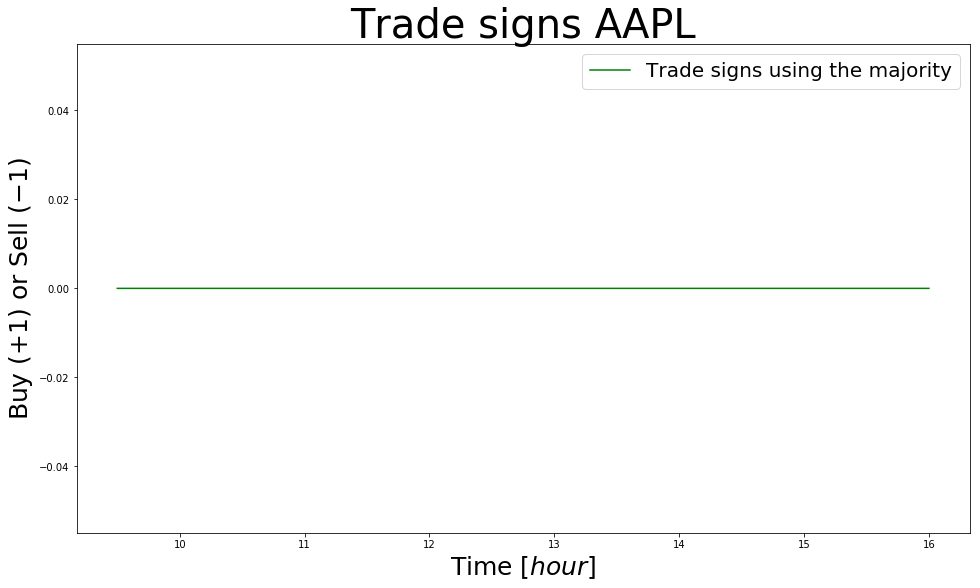

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
figure = plt.figure(figsize=(16, 9))

plt.plot(full_time / 1000 / 3600,
         trade_signs_complete_most, '-g',
         label='Trade signs using the majority')
plt.title('Trade signs {}'.format(ticker), fontsize=40)
plt.xlabel(r'Time $[hour]$', fontsize=25)
plt.ylabel(r'Buy $(+1)$ or Sell $(-1)$', fontsize=25)
plt.legend(loc='best', fontsize=20)